In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [4]:
# 1. Load and preprocess dataset
df = pd.read_csv('DATASET_FINAL_NO_STOPWORDS.csv')

In [5]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [6]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

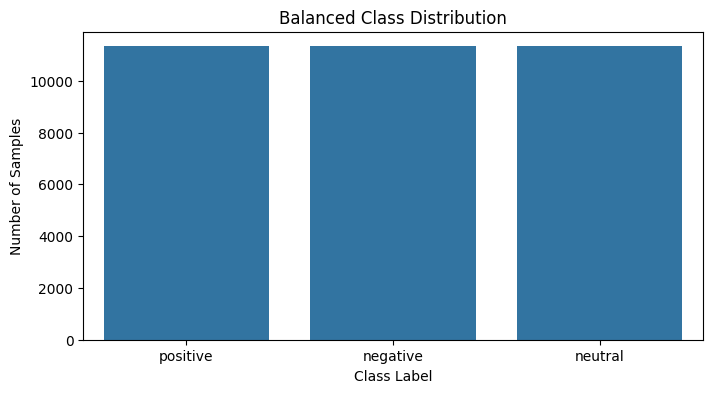

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Balance the dataset by upsampling minority classes
from sklearn.utils import resample

# Combine texts and labels into a DataFrame
balance_df = pd.DataFrame({'text': texts, 'label': labels})

# Find the maximum class size
max_size = balance_df['label'].value_counts().max()

# Upsample each class to max_size
balanced_list = []
for label in balance_df['label'].unique():
    class_subset = balance_df[balance_df['label'] == label]
    upsampled = resample(class_subset, replace=True, n_samples=max_size, random_state=42)
    balanced_list.append(upsampled)
balanced_df = pd.concat(balanced_list)

# Visualize new class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=balanced_df['label'])
plt.title('Balanced Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# Update texts and labels for further processing
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

In [8]:
# Re-encode labels after balancing
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [9]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [10]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [11]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    # Track and plot training/validation loss and accuracy for each fold and model
    train_histories = {'CNN': [], 'RNN': [], 'LSTM': []}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]
        y_val_labels = y[val_idx]
        vocab_size = min(10000, len(tokenizer.word_index) + 1)

        for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
            model = build_fn(maxlen, vocab_size, num_classes)
            history = model.fit(
                X_train, y_train,
                epochs=5,
                batch_size=32,
                verbose=0,
                validation_data=(X_val, y_val)
            )
            train_histories[name].append(history)


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 1 CNN: Acc=0.8484, Prec=0.8479, Rec=0.8484, F1=0.8479, MCC=0.7728, MSE=0.2229, RMSE=0.4721, R2=0.6664


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 RNN: Acc=0.8010, Prec=0.8260, Rec=0.8010, F1=0.7986, MCC=0.7152, MSE=0.3177, RMSE=0.5636, R2=0.5245


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Fold 1 LSTM: Acc=0.8312, Prec=0.8303, Rec=0.8312, F1=0.8305, MCC=0.7469, MSE=0.2422, RMSE=0.4921, R2=0.6375


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2 CNN: Acc=0.8453, Prec=0.8463, Rec=0.8453, F1=0.8453, MCC=0.7684, MSE=0.2177, RMSE=0.4666, R2=0.6732


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2 RNN: Acc=0.8296, Prec=0.8285, Rec=0.8296, F1=0.8284, MCC=0.7449, MSE=0.2470, RMSE=0.4969, R2=0.6293


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Fold 2 LSTM: Acc=0.8198, Prec=0.8225, Rec=0.8198, F1=0.8199, MCC=0.7308, MSE=0.2565, RMSE=0.5064, R2=0.6150


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 3 CNN: Acc=0.8375, Prec=0.8387, Rec=0.8375, F1=0.8379, MCC=0.7564, MSE=0.2139, RMSE=0.4624, R2=0.6788


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 RNN: Acc=0.8304, Prec=0.8311, Rec=0.8304, F1=0.8304, MCC=0.7458, MSE=0.2401, RMSE=0.4900, R2=0.6394


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Fold 3 LSTM: Acc=0.8228, Prec=0.8227, Rec=0.8228, F1=0.8227, MCC=0.7342, MSE=0.2487, RMSE=0.4987, R2=0.6264


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


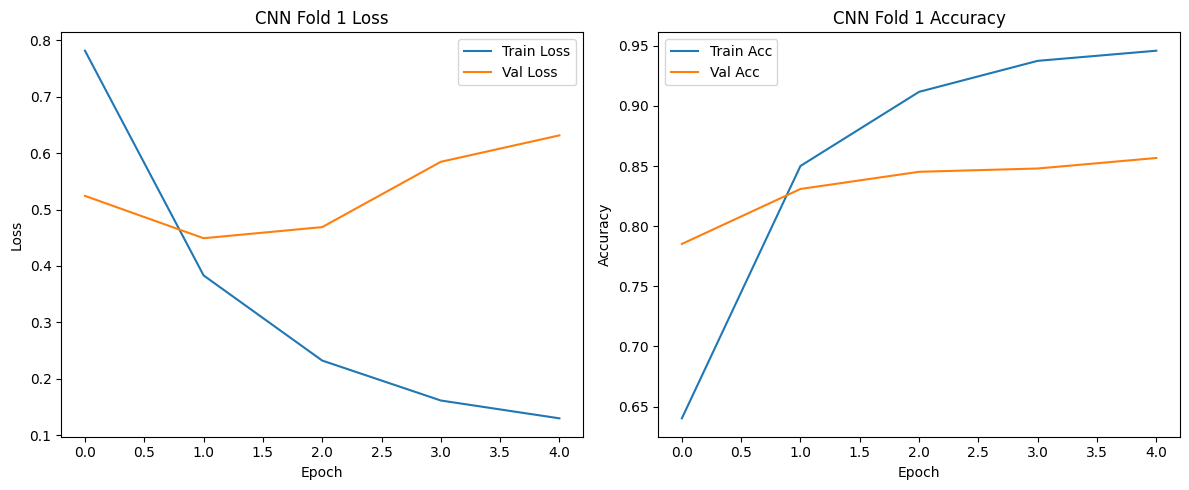

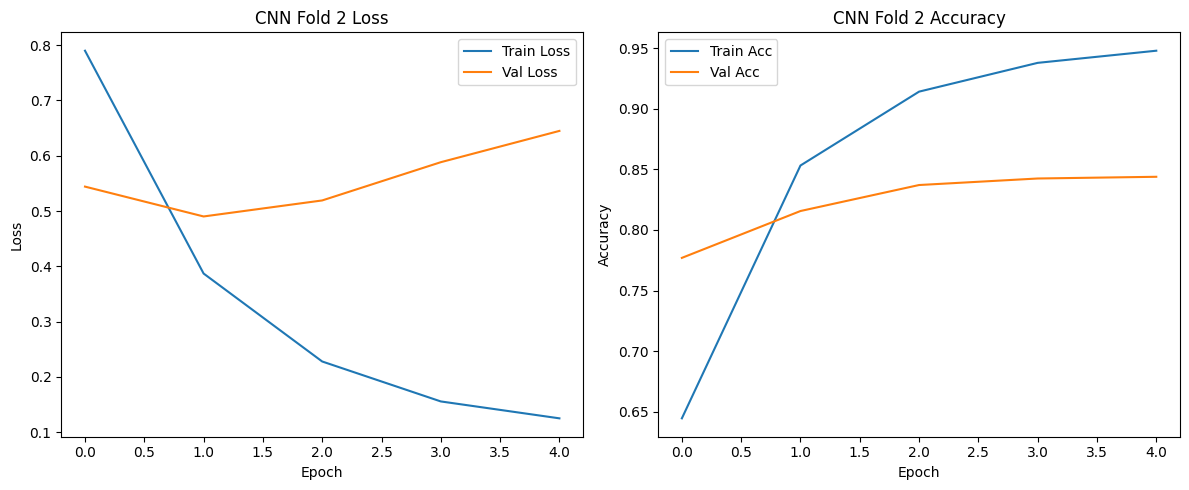

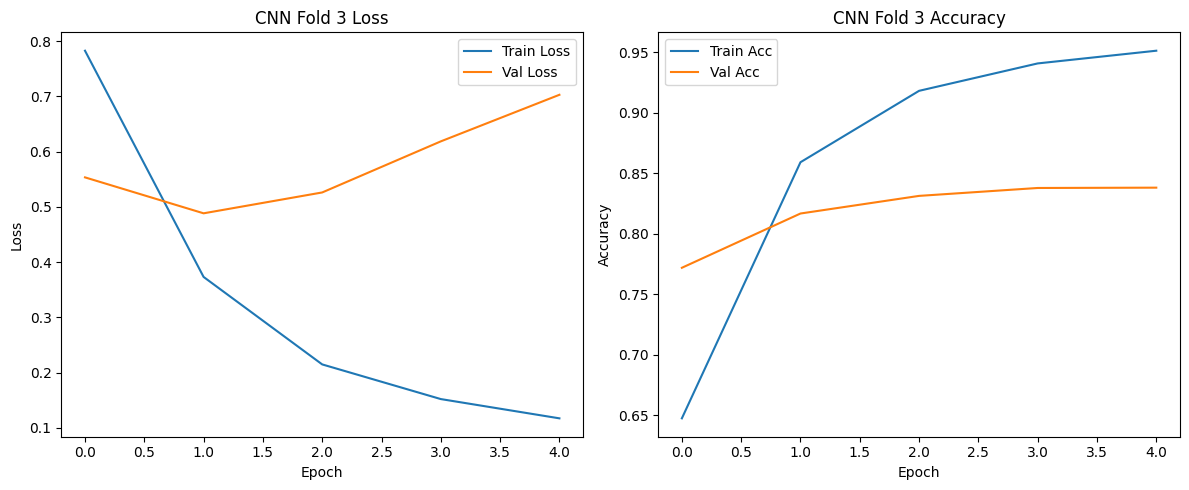

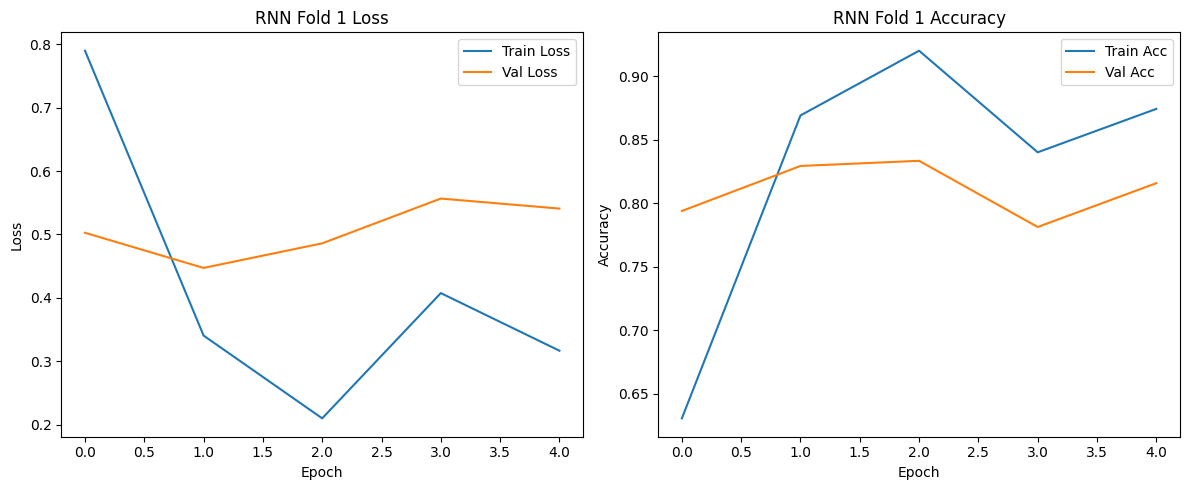

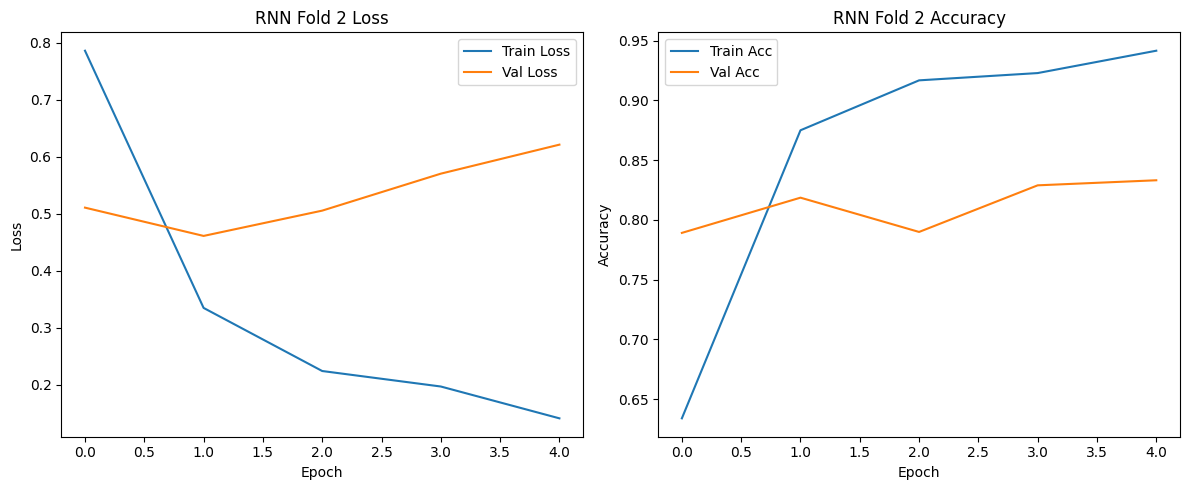

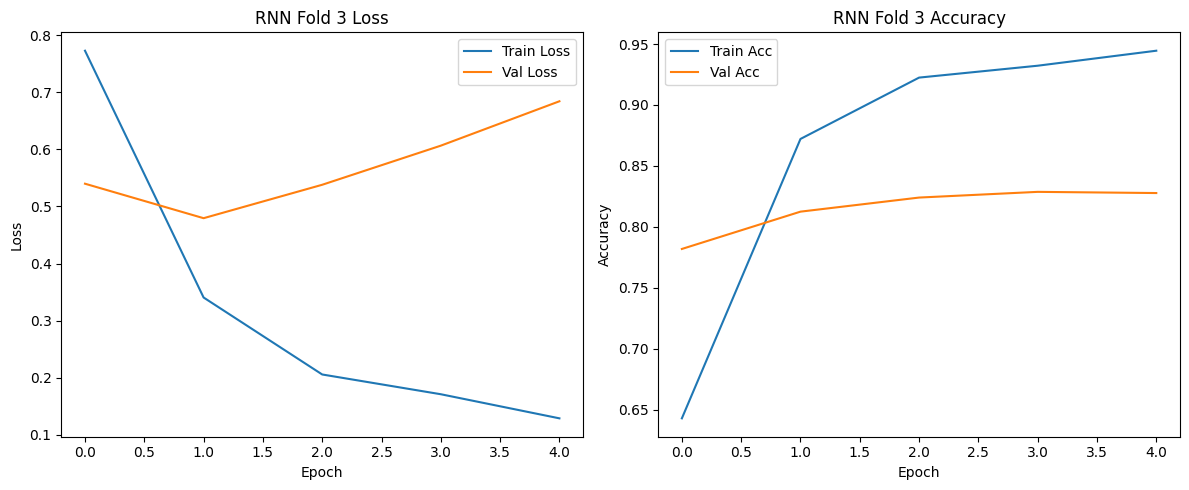

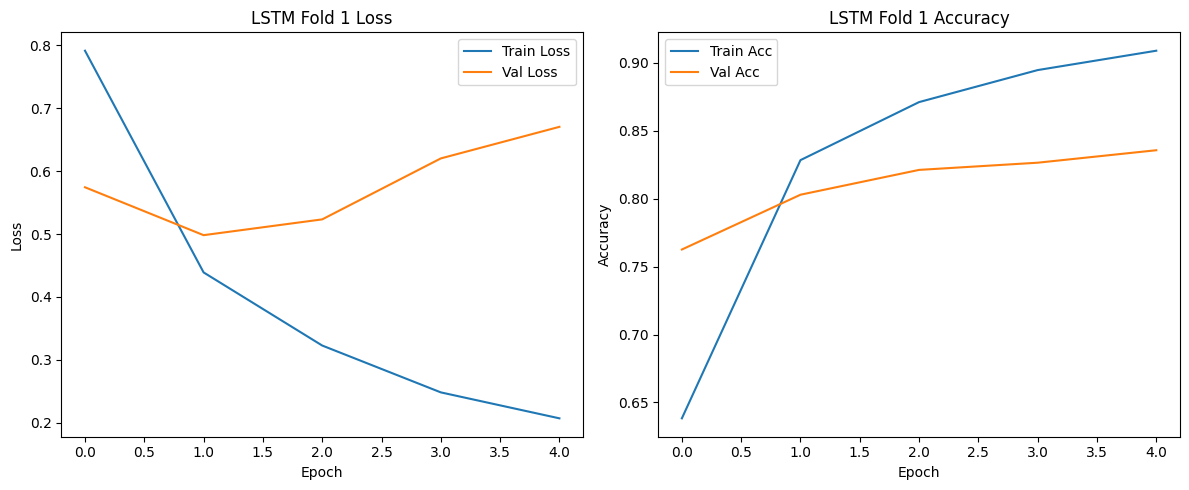

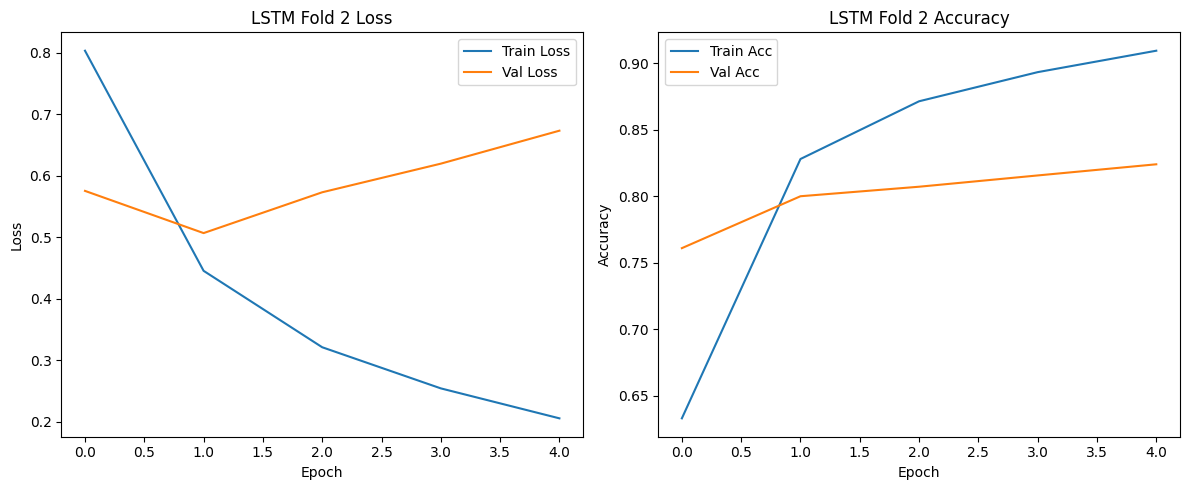

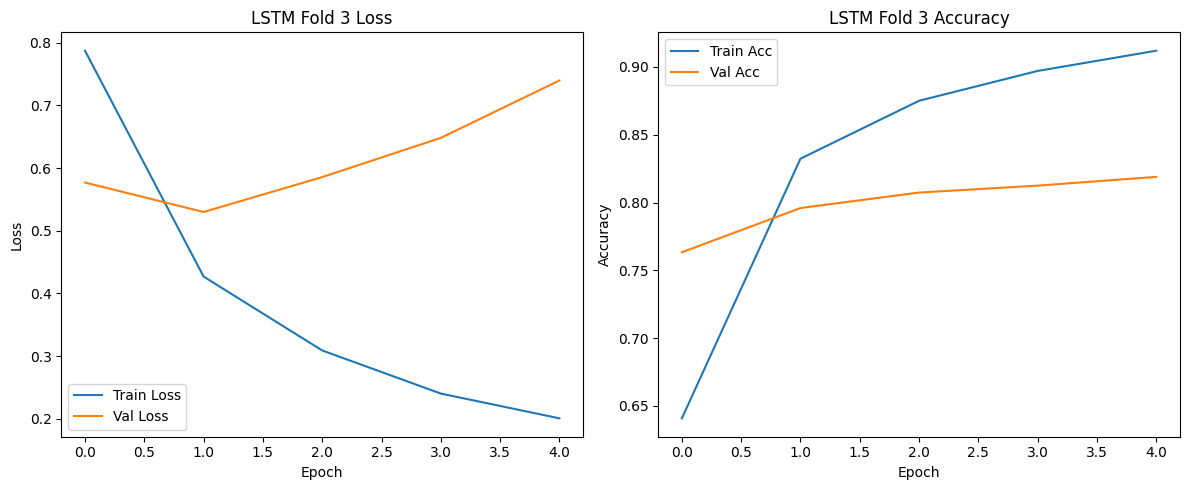

In [13]:
# Plot training/validation loss and accuracy curves
import matplotlib.pyplot as plt
for name in train_histories:
    for fold_idx, history in enumerate(train_histories[name]):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Fold {fold_idx+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{name} Fold {fold_idx+1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [14]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.8437
precision: 0.8443
recall: 0.8437
f1: 0.8437
mcc: 0.7659
mse: 0.2182
rmse: 0.4671
r2: 0.6728

RNN Average Metrics:
accuracy: 0.8203
precision: 0.8285
recall: 0.8203
f1: 0.8191
mcc: 0.7353
mse: 0.2682
rmse: 0.5168
r2: 0.5977

LSTM Average Metrics:
accuracy: 0.8246
precision: 0.8252
recall: 0.8246
f1: 0.8244
mcc: 0.7373
mse: 0.2491
rmse: 0.4991
r2: 0.6263


In [15]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [16]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is CNN (score: 0.8437)
For precision, the winner is CNN (score: 0.8443)
For recall, the winner is CNN (score: 0.8437)
For f1, the winner is CNN (score: 0.8437)
For mcc, the winner is CNN (score: 0.7659)
For mse, the winner is CNN (score: 0.2182)
For rmse, the winner is CNN (score: 0.4671)
For r2, the winner is CNN (score: 0.6728)

Overall Best Model: CNN
This is because CNN achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


In [17]:
# After cross-validation, select the best model and tokenizer
# For example, if CNN is the best:
cnn_model = build_cnn(maxlen, vocab_size, num_classes)
cnn_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)  # Train on full data
cnn_tokenizer = tokenizer  # If you used one tokenizer for all, otherwise assign the correct one

rnn_model = build_rnn(maxlen, vocab_size, num_classes)
rnn_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)
rnn_tokenizer = tokenizer

lstm_model = build_lstm(maxlen, vocab_size, num_classes)
lstm_model.fit(X, y_cat, epochs=5, batch_size=32, verbose=1)
lstm_tokenizer = tokenizer

Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6904 - loss: 0.6996
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8750 - loss: 0.3263
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9251 - loss: 0.1953
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9402 - loss: 0.1426
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9487 - loss: 0.1195
Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6876 - loss: 0.6891
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8935 - loss: 0.2859
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9009 - loss: 0.2475
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8778 - loss: 0.3012
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9237 - loss: 0.1872
Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.6905 - loss: 0.7074
Epoch 2/5
1063/1063 ━

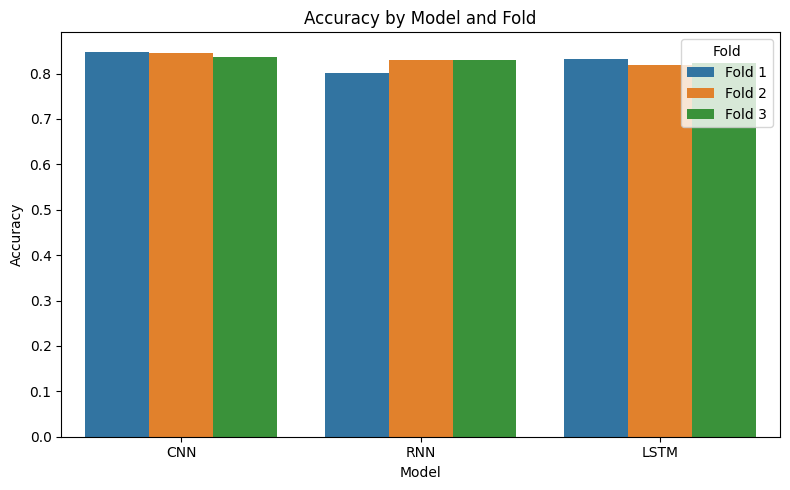

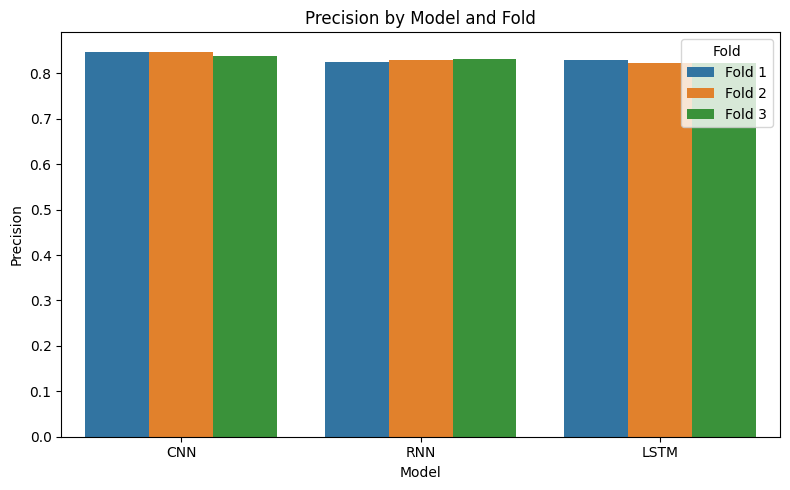

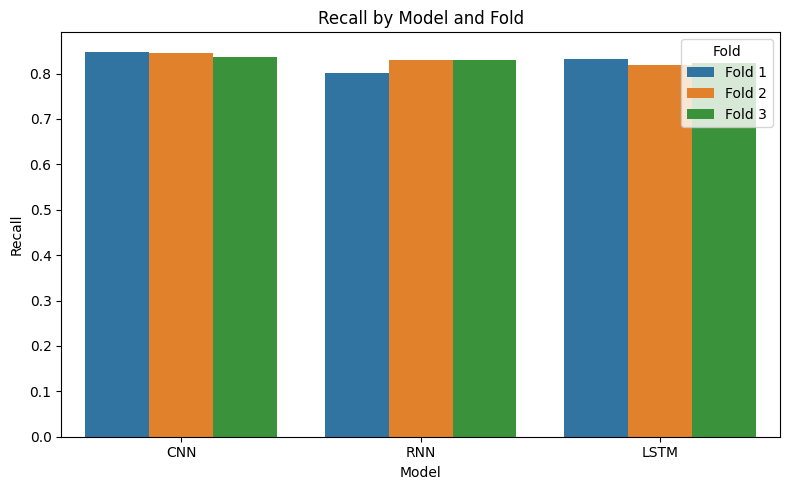

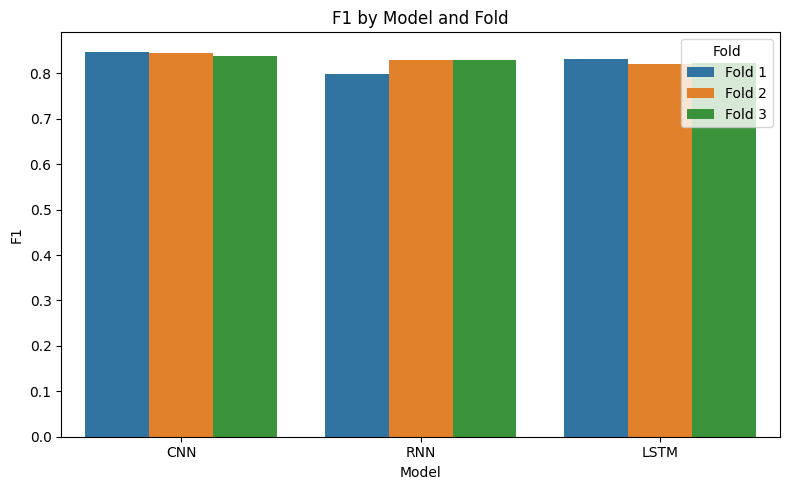

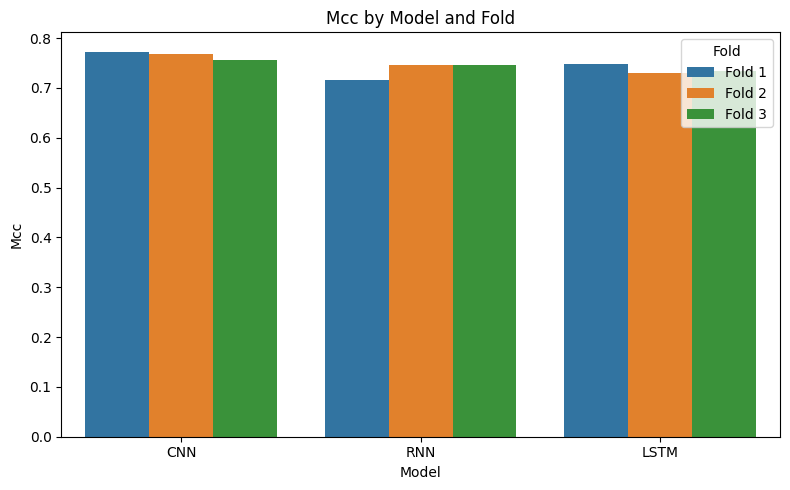

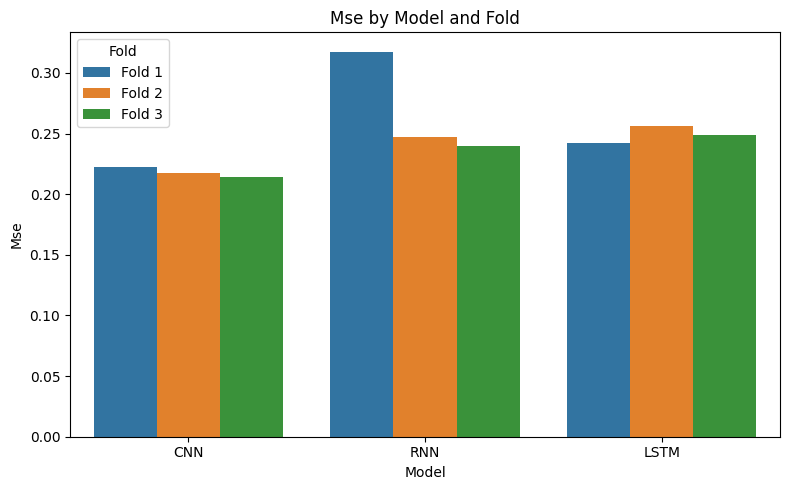

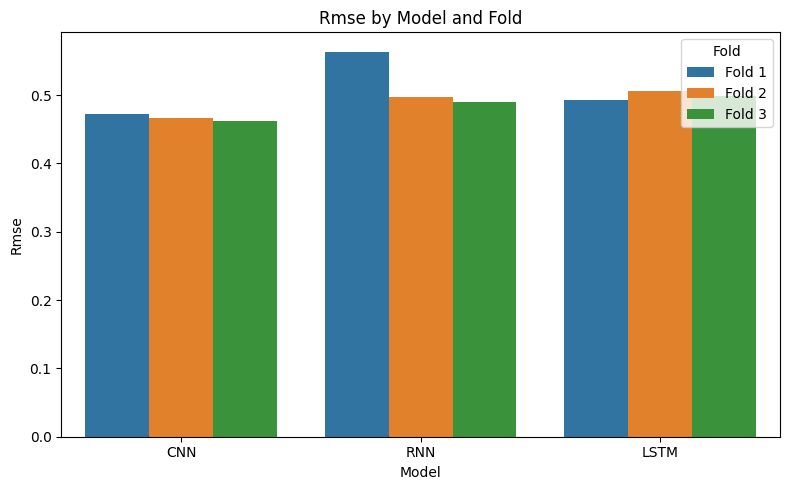

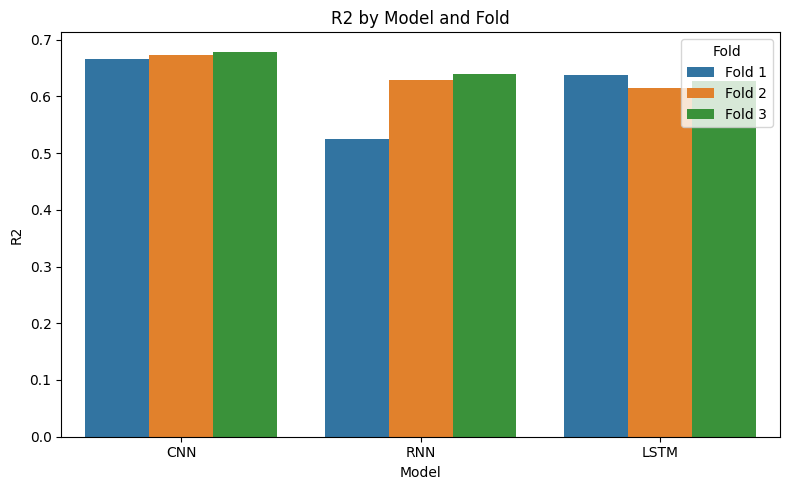

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

In [19]:
# import pickle

# models_dict = {'CNN': [cnn_fold1, cnn_fold2], ...}
# tokenizers_dict = {'CNN': [cnn_tokenizer_fold1, cnn_tokenizer_fold2], ...}

# for name in ['CNN', 'RNN', 'LSTM']:
#     for fold_idx, model in enumerate(models_dict[name]):
#         model_filename = f'{name.lower()}_fold{fold_idx+1}_model.h5'
#         tokenizer_filename = f'{name.lower()}_fold{fold_idx+1}_tokenizer.pkl'
#         # Save model
#         model.save(model_filename)
#         # Save corresponding tokenizer
#         with open(tokenizer_filename, 'wb') as f:
#             pickle.dump(tokenizers_dict[name][fold_idx], f)
#         print(f'Saved {model_filename} and {tokenizer_filename}')

In [ ]:
import pickle

# Save CNN model and tokenizer
cnn_model.save('cnn_model.keras')
with open('cnn_tokenizer.obj', 'wb') as f:
    pickle.dump(cnn_tokenizer, f)

# Save RNN model and tokenizer
rnn_model.save('rnn_model.keras')
with open('rnn_tokenizer.obj', 'wb') as f:
    pickle.dump(rnn_tokenizer, f)

# Save LSTM model and tokenizer
lstm_model.save('lstm_model.keras')
with open('lstm_tokenizer.obj', 'wb') as f:
    pickle.dump(lstm_tokenizer, f)

print('Saved CNN, RNN, and LSTM models as .keras files and their tokenizers as .obj files.')

Saved CNN, RNN, and LSTM models as .keras files and their tokenizers as .obj files.
